In [1]:
import os

In [2]:
os.listdir('/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)')

['Non Drowsy', 'Drowsy']

In [3]:
from torchvision import datasets

In [4]:
# load the dataset
dataset = datasets.ImageFolder(root="/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)")

# print the class labels
print(dataset.classes)

['Drowsy', 'Non Drowsy']


In [5]:
# view dataset size

print(len(dataset))

41793


In [6]:
# number of images in each class

class_counts = {}

for _, label in dataset.samples:
    if label not in class_counts:
        class_counts[label] = 0
    class_counts[label] += 1

print(f'Drowsy: {class_counts[0]}')
print(f'Not Drowsy: {class_counts[1]}')

Drowsy: 22348
Not Drowsy: 19445


In [7]:
import random

In [8]:
random.seed(43)

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

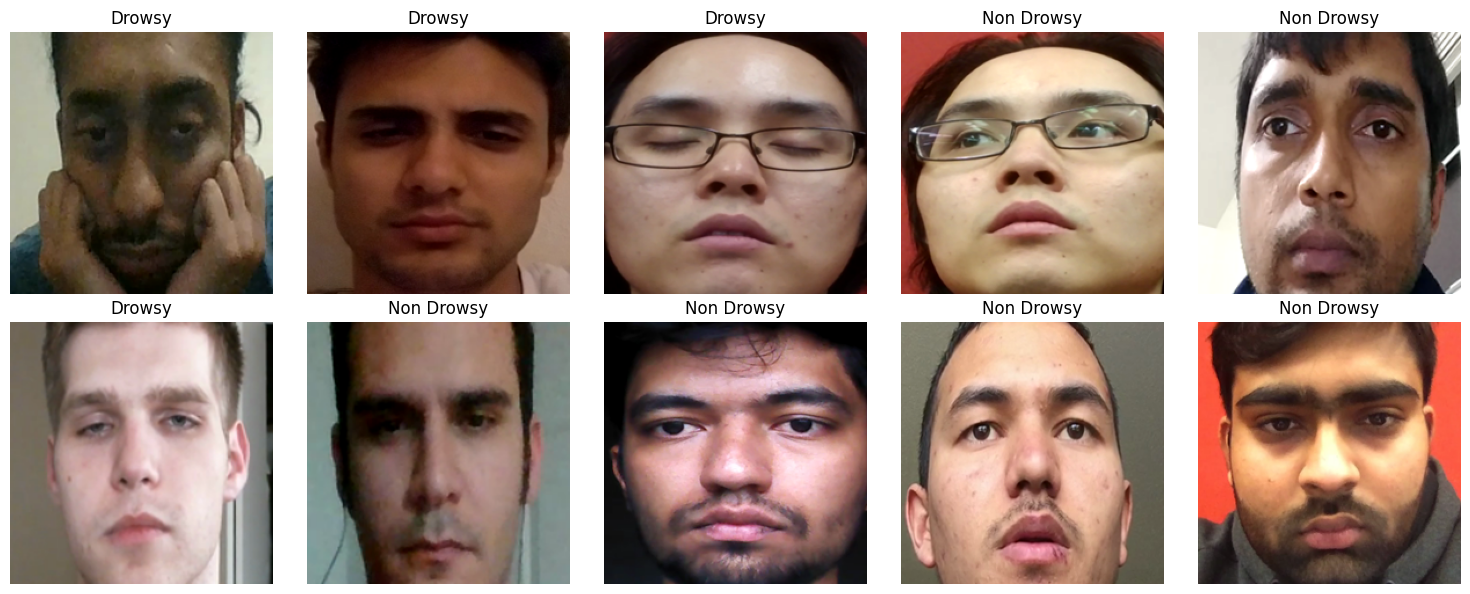

In [10]:
# print 10 random samples from the dataset

random_samples = random.sample(dataset.samples, 10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, (image_path, label) in enumerate(random_samples):
    image = Image.open(image_path)
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(dataset.classes[label])

plt.tight_layout()
plt.show()

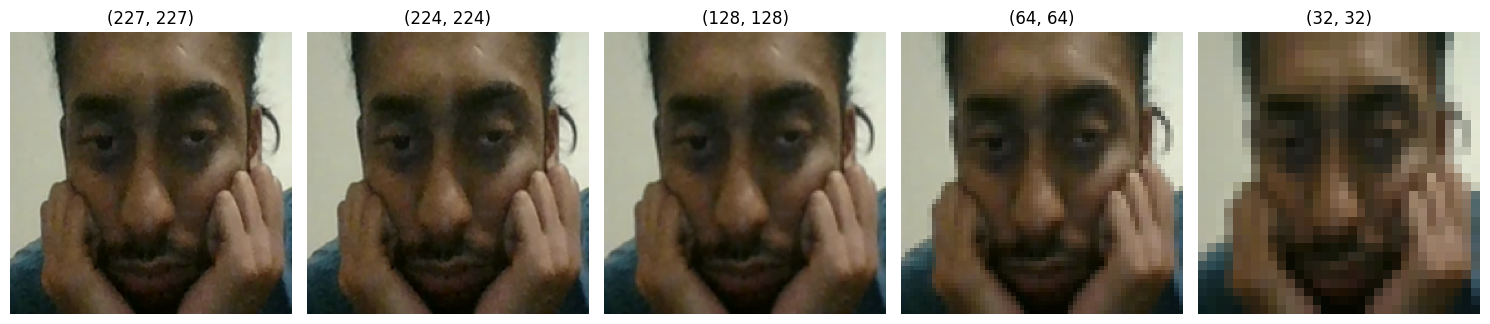

In [11]:
image = Image.open(random_samples[0][0])

# resize the image to different sizes
image_original = image
image_224 = image.resize((224, 224))
image_128 = image.resize((128, 128))
image_64 = image.resize((64, 64))
image_32 = image.resize((32, 32))

# show images
images = [image_original, image_224, image_128, image_64, image_32]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(img.size)

plt.tight_layout()
plt.show()

In [12]:
from torchvision import transforms

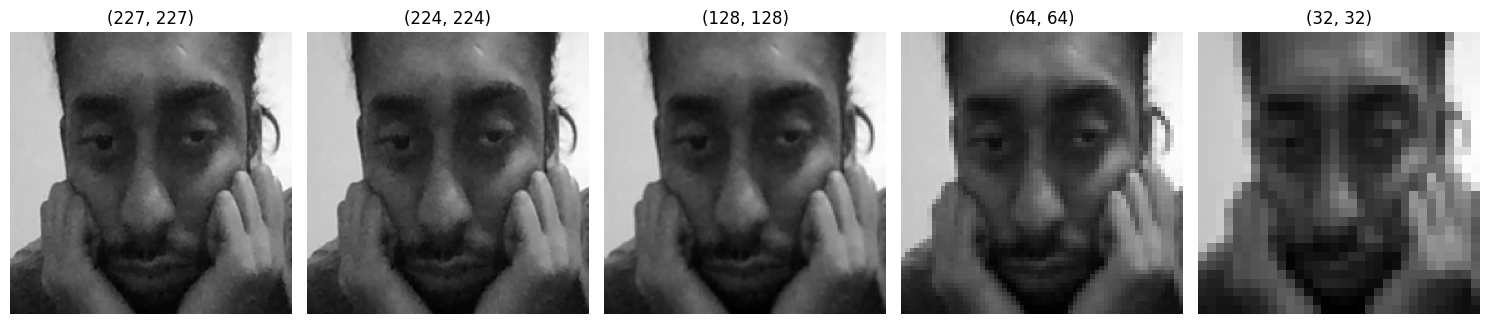

In [13]:
# convert the image to grayscale
grayscale_transform = transforms.Grayscale(num_output_channels=1)

# resize the grayscale image to different sizes
image_gray_original = grayscale_transform(image_original)
image_gray_224 = grayscale_transform(image_224)
image_gray_128 = grayscale_transform(image_128)
image_gray_64 = grayscale_transform(image_64)
image_gray_32 = grayscale_transform(image_32)

# show images
images_gray = [image_gray_original, image_gray_224, image_gray_128, image_gray_64, image_gray_32]
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(images_gray):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(img.size)

plt.tight_layout()
plt.show()

In [14]:
# transform pipeline

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

In [15]:
from torch.utils.data import DataLoader, random_split

In [16]:
# load and transform the drowsiness dataset
drowsiness_dt = datasets.ImageFolder(root="/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)", transform=transform)

# split the dataset train 60%, evaludate 40%
train_size = int(0.6 * len(drowsiness_dt))
val_size = len(drowsiness_dt) - train_size
train_dataset_drowsiness, val_dataset_drowsiness = random_split(drowsiness_dt, [train_size, val_size])

train_loader_drowsiness = DataLoader(train_dataset_drowsiness, batch_size=32, shuffle=True)
val_loader_drowsiness = DataLoader(val_dataset_drowsiness, batch_size=32, shuffle=False)


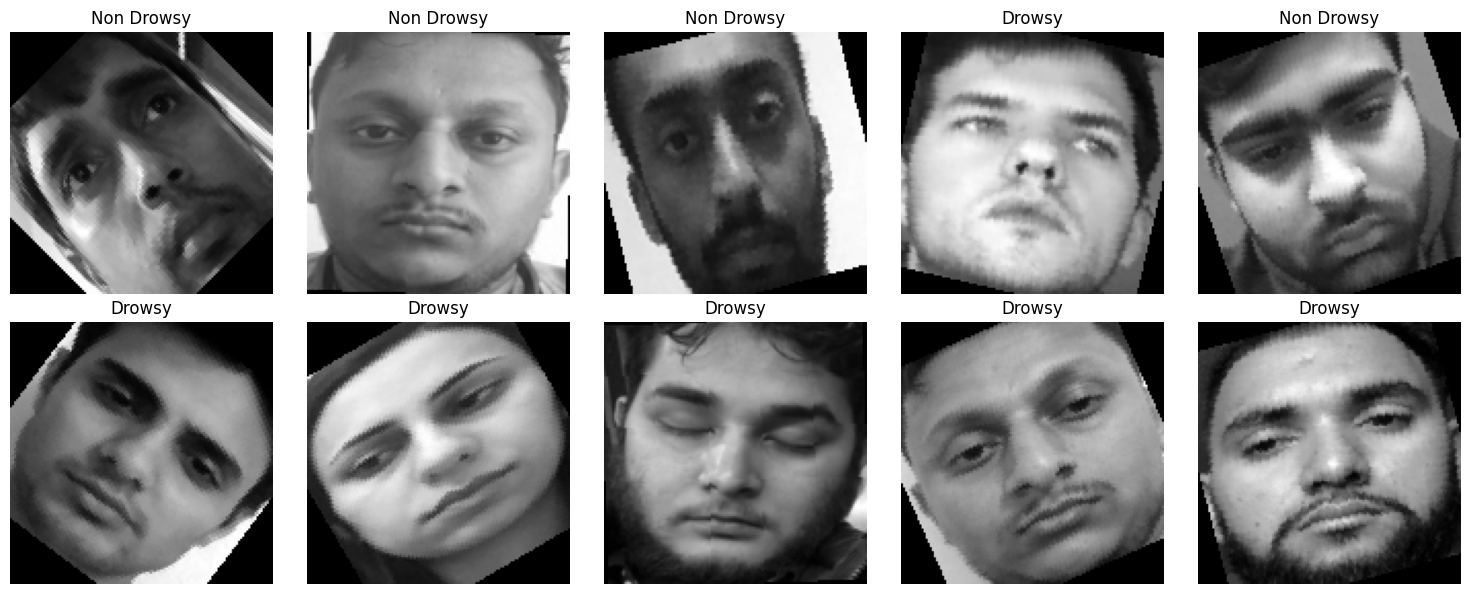

In [17]:
# show the first 10 images

images, labels = next(iter(train_loader_drowsiness))

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(images[i][0], cmap='gray')
    ax.axis('off')
    ax.set_title(dataset.classes[labels[i]])

plt.tight_layout()
plt.show()

In [18]:
# check the size of dataset for each label

train_class_counts = {}
val_class_counts = {}

for _, label in train_dataset_drowsiness:
    if label not in train_class_counts:
        train_class_counts[label] = 0
    train_class_counts[label] += 1

for _, label in val_dataset_drowsiness:
    if label not in val_class_counts:
        val_class_counts[label] = 0
    val_class_counts[label] += 1

print(f'Train Drowsy: {train_class_counts[0]}')
print(f'Train Not Drowsy: {train_class_counts[1]}')
print(f'Validation Drowsy: {val_class_counts[0]}')
print(f'Validation Not Drowsy: {val_class_counts[1]}')

Train Drowsy: 13505
Train Not Drowsy: 11570
Validation Drowsy: 8843
Validation Not Drowsy: 7875


In [19]:
from torchvision import models
from torch import cuda
import torch.nn as nn
import torch.optim as optim

In [20]:
# Load EfficientNet-B0 without pretrained weights
model = models.efficientnet_b0(pretrained=False)

# Modify the first conv layer to accept 1-channel input instead of 3
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the classifier for binary classification
model.classifier[1] = nn.Linear(in_features=1280, out_features=1)

# Set device
device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
from torch import sigmoid
from torch import no_grad

In [22]:
num_epochs = 10
device = 'cuda' if cuda.is_available() else 'cpu'

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_drowsiness:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader_drowsiness)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with no_grad():
        for images, labels in val_loader_drowsiness:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = (sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = 100 * correct / total
    avg_val_loss = val_running_loss / len(val_loader_drowsiness)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/10], Training Loss: 0.2181, Training Accuracy: 90.55%, Validation Loss: 0.0112, Validation Accuracy: 99.73%
Epoch [2/10], Training Loss: 0.0423, Training Accuracy: 98.67%, Validation Loss: 0.0074, Validation Accuracy: 99.81%
Epoch [3/10], Training Loss: 0.0252, Training Accuracy: 99.15%, Validation Loss: 0.0059, Validation Accuracy: 99.84%
Epoch [4/10], Training Loss: 0.0195, Training Accuracy: 99.38%, Validation Loss: 0.0143, Validation Accuracy: 99.64%
Epoch [5/10], Training Loss: 0.0245, Training Accuracy: 99.29%, Validation Loss: 0.0073, Validation Accuracy: 99.84%
Epoch [6/10], Training Loss: 0.0161, Training Accuracy: 99.57%, Validation Loss: 0.0154, Validation Accuracy: 99.46%
Epoch [7/10], Training Loss: 0.0147, Training Accuracy: 99.59%, Validation Loss: 0.0045, Validation Accuracy: 99.92%
Epoch [8/10], Training Loss: 0.0114, Training Accuracy: 99.71%, Validation Loss: 0.0041, Validation Accuracy: 99.92%
Epoch [9/10], Training Loss: 0.0143, Training Accuracy: 99.63%, 

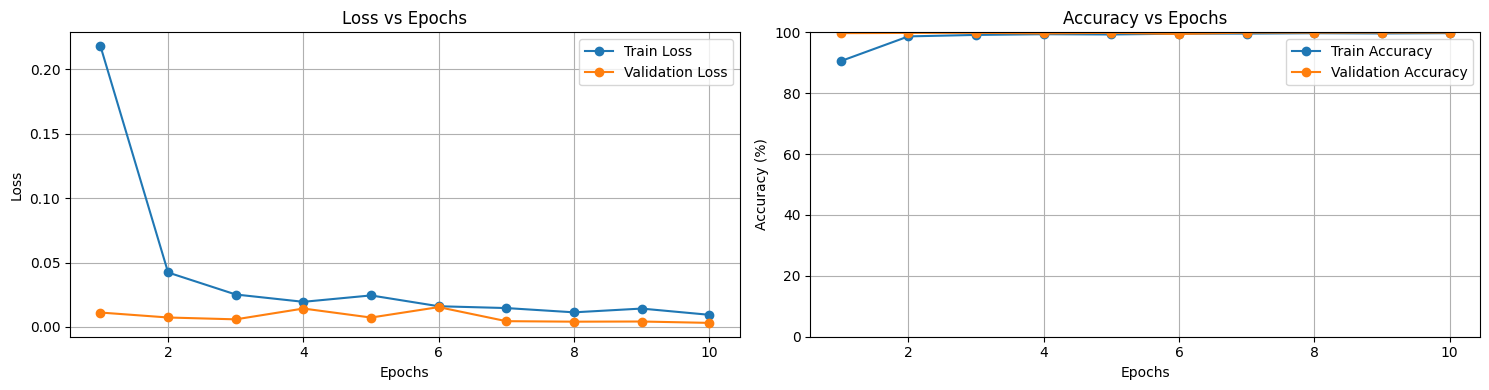

In [23]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [24]:
# Load EfficientNet-B0 without pretrained weights
model = models.efficientnet_b0(pretrained=False)

# Modify the first conv layer to accept 1-channel input instead of 3
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the classifier for binary classification
model.classifier[1] = nn.Linear(in_features=1280, out_features=1)

# Set device
device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop placeholders (use your existing loop code)
num_epochs = 6
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_drowsiness:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader_drowsiness)
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

# Validation
model.eval()
val_running_loss = 0.0
correct = 0
total = 0

with no_grad():
    for images, labels in val_loader_drowsiness:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        predicted = (sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Save predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = 100 * correct / total
avg_val_loss = val_running_loss / len(val_loader_drowsiness)
val_loss_list.append(avg_val_loss)
val_acc_list.append(val_accuracy)

print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
      f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Training Loss: 0.0169, Training Accuracy: 99.47%, Validation Loss: 0.0052, Validation Accuracy: 99.87%


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


Classification Report:
              precision    recall  f1-score   support

  Not Drowsy       1.00      1.00      1.00      8843
      Drowsy       1.00      1.00      1.00      7875

    accuracy                           1.00     16718
   macro avg       1.00      1.00      1.00     16718
weighted avg       1.00      1.00      1.00     16718



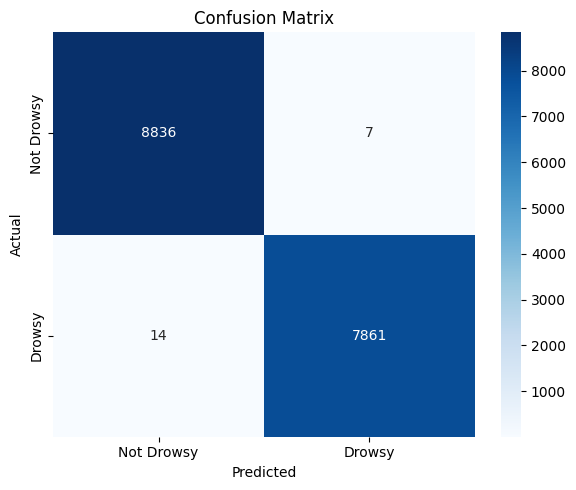

In [26]:
all_preds = [int(p[0]) for p in all_preds]
all_labels = [int(l[0]) for l in all_labels]

# classification report (includes precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Drowsy", "Drowsy"]))

# confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Drowsy", "Drowsy"], yticklabels=["Not Drowsy", "Drowsy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [27]:
from torch import save

In [28]:
save(model.state_dict(), '/kaggle/working/Drowsiness-EfficientNetB0.pth')